In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import treecorr
import healpy as hp
import os

from importlib import reload

import somoclu

import time

start_time = time.time()

import sys
sys.path.append('src')

In [2]:
GETBACK=sys.path

In [3]:
current_path = os.getcwd()  # Obtiene el directorio actual
parent_path = os.path.dirname(current_path)  # Sube un nivel
os.chdir(parent_path)  # Cambia al directorio padre
sys.path = os.getcwd()

In [4]:
GETBACK2=sys.path

In [5]:
catwo = pd.read_parquet("property_maps_desy3_small.parquet.gzip")
catwo = catwo.drop(['HPIX_4096','FOREGROUND_MASK','BADREGIONS_MASK','EBV_SFD98'], axis=1)
catwo = catwo.iloc[0:0]

In [6]:
sys.path=GETBACK2
os.chdir("Modulos")

In [7]:
MainArray = np.loadtxt("Main_Parmeters.txt")

In [8]:
som_dim = int(MainArray[0])
JoyDiv=int(MainArray[1])
dif=int(MainArray[2])
JD=int(MainArray[3])
SJ=int(MainArray[4])
Bin=0

del MainArray

In [9]:
cat = pd.read_parquet("property_maps_desy3PIX.parquet.gzip")

In [10]:
redmagic_df = pd.read_parquet("MagicianRedFULL.parquet.gzip")

In [11]:
nside = 4096

hpix = hp.pixelfunc.ang2pix(nside, redmagic_df.ra.values, redmagic_df.dec.values, nest=True, lonlat=True)
npix = hp.nside2npix(nside)
counts = np.zeros(npix, dtype=float)

for pix in hpix:
    counts[pix] = (redmagic_df['HPIX_4096'] == pix).sum()

In [12]:
NumGal = np.array([counts[val] for val in cat.HPIX_4096.values])

In [13]:
cat["NumGal"] = NumGal

In [14]:
Density=[]
for i in range(JoyDiv):
    MSK=cat[cat['Group']==i]
    Density=np.append(Density,(np.sum(MSK['NumGal'])/(len(MSK['NumGal']))))

In [15]:
DensityT=(np.sum(cat['NumGal'])/(len(cat['NumGal'])))

In [16]:
clustering = np.loadtxt("Modulo_ClusteringBMUS.txt")

In [17]:
DOC=[Density[val] for val in cat.Group.values]
Doc=[Density[int(val)] for val in clustering]

In [18]:
SOM = np.loadtxt("Modulo_SOM_RESULTS.txt").reshape((som_dim+dif),som_dim,len(catwo.columns))

In [19]:
sys.path=GETBACK

In [20]:
from matplotlib import cm
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

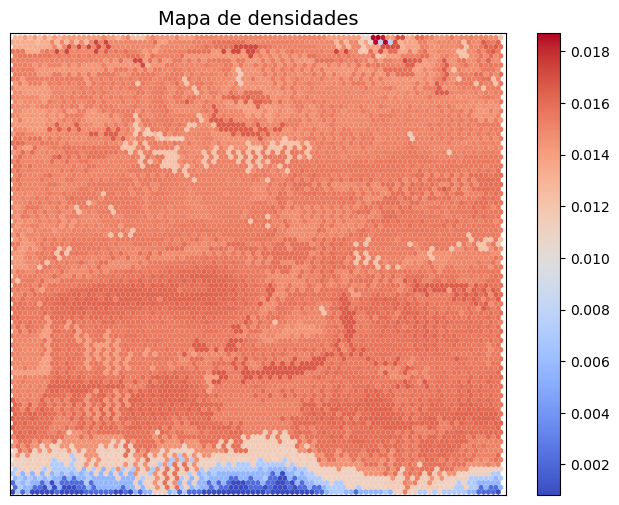

In [21]:
doc = (Doc - min(Doc)) / (max(Doc) - min(Doc))
#print(doc)
doc = doc.reshape(SOM.shape[1], SOM.shape[0])
doc=doc.T
#print(doc)

cmap = plt.cm.coolwarm

fig, ax = plt.subplots(figsize=(8, 6))
hex_size = 1

for i in range(doc.shape[0]):
    for j in range(doc.shape[1]):
        x = i * hex_size * np.sqrt(3) + (j % 2) * hex_size * np.sqrt(3) / 2
        y = j * hex_size * 3/2
        
        hexagon = RegularPolygon((x, y), numVertices=6, radius=hex_size, 
                                 orientation=np.radians(0),
                                 facecolor=plt.cm.coolwarm(doc[i, j]))
        ax.add_patch(hexagon)
        #ax.text(x, y, f'{doc[i, j]*(np.max(Doc) - np.min(Doc))+np.min(Doc):.3f}', ha='center', va='center', color='black', fontsize=8)

ax.set_ylim(-hex_size, doc.shape[1] * hex_size * 3/2)
ax.set_xlim(-hex_size, doc.shape[0] * hex_size * np.sqrt(3)+1)

ax.set_title('Mapa de densidades', fontsize=14)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(Doc), vmax=np.max(Doc)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

plt.xticks([])
plt.yticks([])

plt.show()

In [22]:
DeltaD=Density/DensityT-1
Delta=[DeltaD[int(val)] for val in cat.Group.values]
cat["Delta"] = Delta
delta=[DeltaD[int(val)] for val in clustering]

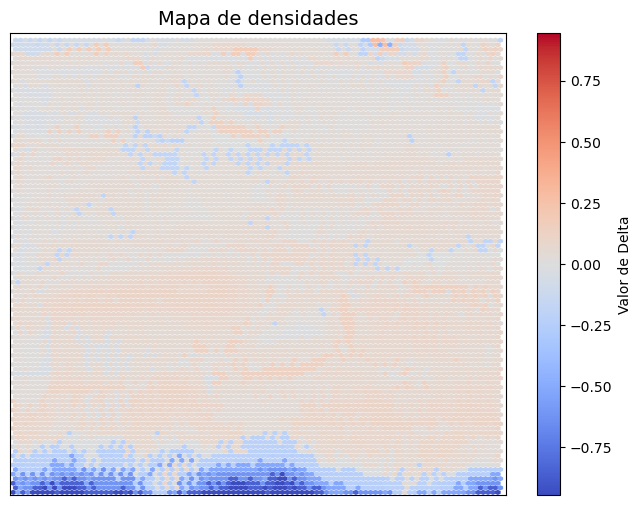

In [23]:
p_low, p_high = np.nanpercentile(delta, [5, 95])#-->La información es mas visualmente entendible
delta2=np.array(delta)
O_density=delta2

delta2 = delta2.reshape(SOM.shape[1], SOM.shape[0])

if abs(max(delta))>abs(min(delta)):
    lim=abs(max(delta))
else:
    lim=abs(min(delta))

fig, ax = plt.subplots(figsize=(8, 6))
hex_size = 1

cmap = plt.cm.coolwarm

for i in range(delta2.shape[0]):
    for j in range(delta2.shape[1]):
        y = i * hex_size * np.sqrt(3) 
        x = j * hex_size * 3/2 + (i%2) * hex_size *  3/4 

        hexagon = RegularPolygon((x, y), numVertices=6, radius=hex_size, 
                                 orientation=np.radians(0), 
                                 facecolor=cmap((delta2[i, j] + lim) / (2 * lim)))
        ax.add_patch(hexagon)
        #ax.text(x, y, f'{delta2[i, j]*(np.max(delta) - np.min(delta))+np.min(delta):.3f}', ha='center', va='center', color='black', fontsize=8)

ax.set_xlim(-hex_size, (delta2.shape[1]) * hex_size * 3/2+1)
ax.set_ylim(-hex_size, (delta2.shape[0]) * hex_size * np.sqrt(3)+1)

ax.set_title('Mapa de densidades', fontsize=14)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-lim, vmax=lim))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Valor de Delta')

plt.xticks([])
plt.yticks([])

#filename = os.path.join("plots",f"Mapa_Densidades_SinPesos.png") 
#plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

In [24]:
np.savetxt("delta.txt", delta, fmt="%.15f")

In [25]:
np.savetxt("delta2.txt", delta2.ravel(), fmt="%.15f")